# Generating PID controller data
This series of notebooks explores the idea of emulating PID controller behavior with an LSTM. This first notebook is used to tune a PID controller and generate data from the TCLab for use in training the LSTM. The LSTM can then be used in place of the PID controller (or any other controller it is trained on), or used to evaluate the PID controller performance for anomaly detection.

In [1]:
import tclab
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
import random

In [2]:
# PID Parameters
Kc   = 6.0
tauI = 75.0 # sec
tauD = 0.0  # sec

#-----------------------------------------
# PID Controller
#-----------------------------------------
# inputs ---------------------------------
# sp = setpoint
# pv = current temperature
# pv_last = prior temperature
# ierr = integral error
# dt = time increment between measurements
# outputs --------------------------------
# op = output of the PID controller
# P = proportional contribution
# I = integral contribution
# D = derivative contribution
def pid(sp,pv,pv_last,ierr,dt):
    # PID coefficients in terms of tuning parameters
    KP = Kc
    KI = Kc / tauI
    KD = Kc * tauD
    
    # ubias for controller (initial heater)
    op0 = 0 
    
    # upper and lower bounds on heater level
    ophi = 100
    oplo = 0
    
    # calculate the error
    error = sp - pv
    
    # calculate the integral error
    ierr = ierr + KI * error * dt
    
    # calculate the measurement derivative
    dpv = (pv - pv_last) / dt
    
    # calculate the PID output
    P = KP * error
    I = ierr
    D = -KD * dpv
    op = op0 + P + I + D
    
    # implement anti-reset windup
    if op < oplo or op > ophi:
        I = I - KI * error * dt
        # clip output
        op = max(oplo,min(ophi,op))
        
    # return the controller output and PID terms
    return [op,P,I,D]

TCLab version 0.4.9
Arduino Leonardo connected on port COM3 at 115200 baud.
TCLab Firmware Version 1.01.
TCLab disconnected successfully.


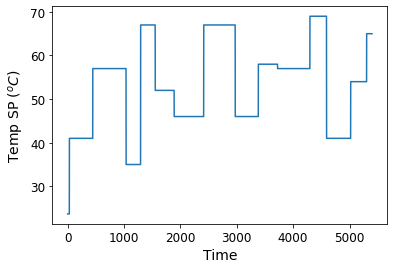

In [3]:
##### Set up run parameters #####

# Run time in minutes
run_time = 90.0

# Number of cycles
loops = int(60.0*run_time)

# arrays for storing data
T1 = np.zeros(loops) # measured T (degC)
Q1 = np.zeros(loops) # Heater values
tm = np.zeros(loops) # Time

# Temperature set point (degC)
with tclab.TCLab() as lab:
    Tsp1 = np.ones(loops) * lab.T1

# vary temperature setpoint
end = 30 # leave 1st 30 seconds of temp set point as room temp
while end <= loops:
    start = end
    # keep new temp set point value for anywhere from 4 to 10 min
    end += random.randint(240,600) 
    Tsp1[start:end] = random.randint(30,70)

# Plot
plt.plot(Tsp1)
plt.xlabel('Time',size=14)
plt.ylabel(r'Temp SP ($^oC$)',size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.savefig('SP_profile.png');

In [4]:
# Run test
with tclab.TCLab() as lab:
    # Find current T1, T2
    print('Temperature 1: {0:0.2f} °C'.format(lab.T1))
    print('Temperature 2: {0:0.2f} °C'.format(lab.T2))

    # Integral error
    ierr = 0.0
    # Integral absolute error
    iae = 0.0

    start_time = time.time()
    prev_time = start_time

    for i in range(loops):
        # Delay 1 second
        if time.time() > prev_time + 1.0:
            print('Exceeded cycle time by ',time.time()-prev_time-1.0)
        else:
            while time.time() < prev_time + 1.0:
                pass
        
        # Record time and change in time
        t = time.time()
        dt = t - prev_time
        prev_time = t
        tm[i] = t - start_time

        # Read temperatures in Kelvin 
        T1[i] = lab.T1

        # Integral absolute error
        iae += np.abs(Tsp1[i]-T1[i])

        # Calculate PID output
        [Q1[i],P,ierr,D] = pid(Tsp1[i],T1[i],T1[i-1],ierr,dt)

        # Write heater output (0-100)
        lab.Q1(Q1[i])

        # Print line of data
        print(('{:6.1f} {:6.2f} {:6.2f} ' + \
              '{:6.2f} {:6.2f} {:6.2f} {:6.2f} {:6.2f}').format( \
                  tm[i],Tsp1[i],T1[i], \
                  Q1[i],P,ierr,D,iae))
        

TCLab version 0.4.9
Arduino Leonardo connected on port COM3 at 115200 baud.
TCLab Firmware Version 1.01.
Temperature 1: 23.73 °C
Temperature 2: 23.15 °C
   1.0  23.67  23.64   0.18   0.18   0.00  -0.00   0.03
   2.0  23.67  23.67   0.00   0.00   0.00  -0.00   0.03
   3.0  23.67  23.80   0.00  -0.78   0.00  -0.00   0.16
   4.0  23.67  23.80   0.00  -0.78   0.00  -0.00   0.29
   5.0  23.67  23.80   0.00  -0.78   0.00  -0.00   0.42
   6.0  23.67  23.80   0.00  -0.78   0.00  -0.00   0.55
   7.0  23.67  23.77   0.00  -0.60   0.00   0.00   0.65
   8.0  23.67  23.80   0.00  -0.78   0.00  -0.00   0.78
   9.0  23.67  23.67   0.00   0.00   0.00   0.00   0.78
  10.0  23.67  23.77   0.00  -0.60   0.00  -0.00   0.88
  11.0  23.67  23.77   0.00  -0.60   0.00  -0.00   0.98
  12.0  23.67  23.77   0.00  -0.60   0.00  -0.00   1.08
  13.0  23.67  23.77   0.00  -0.60   0.00  -0.00   1.18
  14.0  23.67  23.80   0.00  -0.78   0.00  -0.00   1.31
  15.0  23.67  23.73   0.00  -0.36   0.00   0.00   1.37
  16.0 

 145.4  41.00  44.42  16.58 -20.52  37.10  -0.00 893.34
 146.4  41.00  44.42  16.31 -20.52  36.83  -0.00 896.76
 147.4  41.00  44.42  16.03 -20.52  36.55  -0.00 900.18
 148.4  41.00  44.42  15.76 -20.52  36.28  -0.00 903.60
 149.4  41.00  44.42  15.48 -20.52  36.00  -0.00 907.02
 150.4  41.00  44.42  15.21 -20.52  35.73  -0.00 910.44
 151.4  41.00  44.42  14.94 -20.52  35.46  -0.00 913.86
 152.4  41.00  44.46  14.42 -20.76  35.18  -0.00 917.32
 153.4  41.00  44.42  14.39 -20.52  34.91   0.00 920.74
 154.4  41.00  44.42  14.11 -20.52  34.63  -0.00 924.16
 155.4  41.00  44.42  13.84 -20.52  34.36  -0.00 927.58
 156.4  41.00  44.42  13.56 -20.52  34.08  -0.00 931.00
 157.4  41.00  44.42  13.29 -20.52  33.81  -0.00 934.42
 158.4  41.00  44.42  13.01 -20.52  33.53  -0.00 937.84
 159.4  41.00  44.42  12.74 -20.52  33.26  -0.00 941.26
 160.4  41.00  44.42  12.46 -20.52  32.98  -0.00 944.68
 161.4  41.00  44.42  12.19 -20.52  32.71  -0.00 948.10
 162.4  41.00  44.42  11.92 -20.52  32.44  -0.00

 290.7  41.00  40.46  27.40   3.24  24.16   0.00 1101.37
 291.7  41.00  40.52  27.08   2.88  24.20  -0.00 1101.85
 292.7  41.00  40.56  26.87   2.64  24.23  -0.00 1102.29
 293.7  41.00  40.56  26.91   2.64  24.27  -0.00 1102.73
 294.7  41.00  40.56  26.94   2.64  24.30  -0.00 1103.17
 295.8  41.00  40.52  27.22   2.88  24.34   0.00 1103.65
 296.8  41.00  40.49  27.44   3.06  24.38   0.00 1104.16
 297.8  41.00  40.46  27.67   3.24  24.43   0.00 1104.70
 298.8  41.00  40.46  27.71   3.24  24.47  -0.00 1105.24
 299.8  41.00  40.46  27.75   3.24  24.51  -0.00 1105.78
 300.8  41.00  40.27  28.95   4.38  24.57   0.00 1106.51
 301.8  41.00  40.49  27.67   3.06  24.61  -0.00 1107.02
 302.8  41.00  40.56  27.29   2.64  24.65  -0.00 1107.46
 303.8  41.00  40.52  27.57   2.88  24.69   0.00 1107.94
 304.8  41.00  40.56  27.36   2.64  24.72  -0.00 1108.38
 305.8  41.00  40.56  27.40   2.64  24.76  -0.00 1108.82
 306.8  41.00  40.56  27.43   2.64  24.79  -0.00 1109.26
 307.8  41.00  40.56  27.47   2

 435.1  41.00  40.88  25.66   0.72  24.94  -0.00 1135.55
 436.1  41.00  40.88  25.67   0.72  24.95  -0.00 1135.67
 437.1  41.00  40.88  25.68   0.72  24.96  -0.00 1135.79
 438.1  41.00  40.88  25.69   0.72  24.97  -0.00 1135.91
 439.1  41.00  40.88  25.70   0.72  24.98  -0.00 1136.03
 440.1  41.00  40.88  25.71   0.72  24.99  -0.00 1136.15
 441.1  41.00  40.88  25.72   0.72  25.00  -0.00 1136.27
 442.2  41.00  40.88  25.73   0.72  25.01  -0.00 1136.39
 443.2  41.00  40.88  25.74   0.72  25.02  -0.00 1136.51
 444.2  41.00  40.88  25.75   0.72  25.03  -0.00 1136.63
 445.2  41.00  40.88  25.76   0.72  25.04  -0.00 1136.75
 446.2  41.00  40.88  25.77   0.72  25.05  -0.00 1136.87
 447.2  57.00  40.88 100.00  96.72  25.05  -0.00 1152.99
 448.2  57.00  40.88 100.00  96.72  25.05  -0.00 1169.11
 449.2  57.00  40.91 100.00  96.54  25.05  -0.00 1185.20
 450.2  57.00  40.88 100.00  96.72  25.05   0.00 1201.32
 451.2  57.00  40.88 100.00  96.72  25.05  -0.00 1217.44
 452.2  57.00  41.07 100.00  95

 579.5  57.00  58.60  40.25  -9.60  49.85  -0.00 2030.86
 580.5  57.00  58.60  40.12  -9.60  49.72  -0.00 2032.46
 581.5  57.00  58.60  39.99  -9.60  49.59  -0.00 2034.06
 582.5  57.00  58.60  39.86  -9.60  49.46  -0.00 2035.66
 583.5  57.00  58.60  39.73  -9.60  49.33  -0.00 2037.26
 584.5  57.00  58.60  39.61  -9.60  49.21  -0.00 2038.86
 585.5  57.00  58.60  39.48  -9.60  49.08  -0.00 2040.46
 586.5  57.00  58.60  39.35  -9.60  48.95  -0.00 2042.06
 587.5  57.00  58.60  39.22  -9.60  48.82  -0.00 2043.66
 588.5  57.00  58.57  39.27  -9.42  48.69   0.00 2045.23
 589.5  57.00  58.54  39.33  -9.24  48.57   0.00 2046.77
 590.5  57.00  58.44  39.81  -8.64  48.45   0.00 2048.21
 591.6  57.00  58.57  38.91  -9.42  48.33  -0.00 2049.78
 592.6  57.00  58.44  39.57  -8.64  48.21   0.00 2051.22
 593.6  57.00  58.35  40.01  -8.10  48.11   0.00 2052.57
 594.6  57.00  58.28  40.32  -7.68  48.00   0.00 2053.85
 595.6  57.00  58.28  40.22  -7.68  47.90  -0.00 2055.13
 596.6  57.00  58.28  40.12  -7

 723.8  57.00  56.67  51.84   1.98  49.86  -0.00 2139.92
 724.9  57.00  56.64  52.05   2.16  49.89   0.00 2140.28
 725.9  57.00  56.67  51.89   1.98  49.91  -0.00 2140.61
 726.9  57.00  56.67  51.92   1.98  49.94  -0.00 2140.94
 727.9  57.00  56.67  51.95   1.98  49.97  -0.00 2141.27
 728.9  57.00  56.67  51.97   1.98  49.99  -0.00 2141.60
 729.9  57.00  56.67  52.00   1.98  50.02  -0.00 2141.93
 730.9  57.00  56.67  52.03   1.98  50.05  -0.00 2142.26
 731.9  57.00  56.67  52.05   1.98  50.07  -0.00 2142.59
 732.9  57.00  56.67  52.08   1.98  50.10  -0.00 2142.92
 733.9  57.00  56.67  52.11   1.98  50.13  -0.00 2143.25
 734.9  57.00  56.67  52.13   1.98  50.15  -0.00 2143.58
 735.9  57.00  56.67  52.16   1.98  50.18  -0.00 2143.91
 736.9  57.00  56.73  51.82   1.62  50.20  -0.00 2144.18
 737.9  57.00  56.67  52.21   1.98  50.23   0.00 2144.51
 738.9  57.00  56.70  52.05   1.80  50.25  -0.00 2144.81
 739.9  57.00  56.73  51.89   1.62  50.27  -0.00 2145.08
 740.9  57.00  56.86  51.12   0

 868.2  57.00  57.31  46.81  -1.86  48.67  -0.00 2167.34
 869.2  57.00  57.31  46.79  -1.86  48.65  -0.00 2167.65
 870.2  57.00  57.25  47.13  -1.50  48.63   0.00 2167.90
 871.2  57.00  57.25  47.11  -1.50  48.61  -0.00 2168.15
 872.2  57.00  57.12  47.88  -0.72  48.60   0.00 2168.27
 873.2  57.00  57.02  48.48  -0.12  48.60   0.00 2168.29
 874.2  57.00  57.15  47.69  -0.90  48.59  -0.00 2168.44
 875.2  57.00  56.99  48.65   0.06  48.59   0.00 2168.45
 876.2  57.00  57.06  48.22  -0.36  48.58  -0.00 2168.51
 877.2  57.00  57.09  48.04  -0.54  48.58  -0.00 2168.60
 878.3  57.00  57.09  48.03  -0.54  48.57  -0.00 2168.69
 879.3  57.00  57.02  48.45  -0.12  48.57   0.00 2168.71
 880.3  57.00  56.99  48.63   0.06  48.57   0.00 2168.72
 881.3  57.00  56.99  48.63   0.06  48.57  -0.00 2168.73
 882.3  57.00  56.99  48.63   0.06  48.57  -0.00 2168.74
 883.3  57.00  56.99  48.63   0.06  48.57  -0.00 2168.75
 884.3  57.00  56.99  48.63   0.06  48.57  -0.00 2168.76
 885.3  57.00  56.99  48.63   0

1012.6  57.00  56.67  50.99   1.98  49.01  -0.00 2175.09
1013.6  57.00  56.67  51.02   1.98  49.04  -0.00 2175.42
1014.6  57.00  56.67  51.04   1.98  49.06  -0.00 2175.75
1015.6  57.00  56.67  51.07   1.98  49.09  -0.00 2176.08
1016.6  57.00  56.67  51.10   1.98  49.12  -0.00 2176.41
1017.6  57.00  56.67  51.12   1.98  49.14  -0.00 2176.74
1018.6  57.00  56.73  50.78   1.62  49.16  -0.00 2177.01
1019.6  57.00  56.90  49.77   0.60  49.17  -0.00 2177.11
1020.6  57.00  56.96  49.41   0.24  49.17  -0.00 2177.15
1021.6  57.00  56.90  49.78   0.60  49.18   0.00 2177.25
1022.6  57.00  56.83  50.22   1.02  49.20   0.00 2177.42
1023.6  57.00  56.93  49.62   0.42  49.20  -0.00 2177.49
1024.6  57.00  56.90  49.81   0.60  49.21   0.00 2177.59
1025.6  57.00  56.86  50.06   0.84  49.22   0.00 2177.73
1026.6  57.00  56.70  51.04   1.80  49.24   0.00 2178.03
1027.6  57.00  56.67  51.25   1.98  49.27   0.00 2178.36
1028.6  57.00  56.67  51.28   1.98  49.30  -0.00 2178.69
1029.6  57.00  56.70  51.12   1

1155.9  35.00  43.49   0.00 -50.94  49.53   0.00 4058.00
1156.9  35.00  43.46   0.00 -50.76  49.53   0.00 4066.46
1157.9  35.00  43.46   0.00 -50.76  49.53  -0.00 4074.92
1158.9  35.00  43.13   0.10 -48.78  48.88   0.00 4083.05
1160.0  35.00  43.13   0.00 -48.78  48.88  -0.00 4091.18
1161.0  35.00  43.13   0.00 -48.78  48.88  -0.00 4099.31
1162.0  35.00  42.81   1.40 -46.86  48.26   0.00 4107.12
1163.0  35.00  42.81   0.77 -46.86  47.63  -0.00 4114.93
1164.0  35.00  42.81   0.13 -46.86  46.99  -0.00 4122.74
1165.0  35.00  42.59   0.85 -45.54  46.39   0.00 4130.33
1166.0  35.00  42.49   0.84 -44.94  45.78   0.00 4137.82
1167.0  35.00  42.49   0.24 -44.94  45.18  -0.00 4145.31
1168.0  35.00  42.46   0.00 -44.76  45.18   0.00 4152.77
1169.0  35.00  42.17   1.58 -43.02  44.60   0.00 4159.94
1170.0  35.00  42.17   1.01 -43.02  44.03  -0.00 4167.11
1171.0  35.00  41.97   1.65 -41.82  43.47   0.00 4174.08
1172.0  35.00  41.85   1.82 -41.10  42.92   0.00 4180.93
1173.0  35.00  41.85   1.27 -41

1300.3  67.00  35.40 100.00 189.60  16.60  -0.00 4603.93
1301.3  67.00  35.40 100.00 189.60  16.60  -0.00 4635.53
1302.3  67.00  35.40 100.00 189.60  16.60  -0.00 4667.13
1303.3  67.00  35.40 100.00 189.60  16.60  -0.00 4698.73
1304.3  67.00  35.40 100.00 189.60  16.60  -0.00 4730.33
1305.3  67.00  35.40 100.00 189.60  16.60  -0.00 4761.93
1306.3  67.00  35.40 100.00 189.60  16.60  -0.00 4793.53
1307.3  67.00  35.56 100.00 188.64  16.60  -0.00 4824.97
1308.3  67.00  35.66 100.00 188.04  16.60  -0.00 4856.31
1309.3  67.00  35.72 100.00 187.68  16.60  -0.00 4887.59
1310.3  67.00  35.72 100.00 187.68  16.60  -0.00 4918.87
1311.4  67.00  35.85 100.00 186.90  16.60  -0.00 4950.02
1312.4  67.00  36.04 100.00 185.76  16.60  -0.00 4980.98
1313.4  67.00  36.04 100.00 185.76  16.60  -0.00 5011.94
1314.4  67.00  36.11 100.00 185.34  16.60  -0.00 5042.83
1315.4  67.00  36.37 100.00 183.78  16.60  -0.00 5073.46
1316.4  67.00  36.37 100.00 183.78  16.60  -0.00 5104.09
1317.4  67.00  36.69 100.00 181

1444.6  67.00  64.08  70.19  17.52  52.67  -0.00 7082.97
1445.6  67.00  64.37  68.66  15.78  52.88  -0.00 7085.60
1446.6  67.00  64.40  68.69  15.60  53.09  -0.00 7088.20
1447.6  67.00  64.40  68.90  15.60  53.30  -0.00 7090.80
1448.6  67.00  64.53  68.32  14.82  53.50  -0.00 7093.27
1449.6  67.00  64.73  67.30  13.62  53.68  -0.00 7095.54
1450.6  67.00  64.73  67.48  13.62  53.86  -0.00 7097.81
1451.6  67.00  64.73  67.66  13.62  54.04  -0.00 7100.08
1452.7  67.00  65.05  65.90  11.70  54.20  -0.00 7102.03
1453.7  67.00  65.05  66.06  11.70  54.36  -0.00 7103.98
1454.7  67.00  65.05  66.21  11.70  54.51  -0.00 7105.93
1455.7  67.00  65.15  65.76  11.10  54.66  -0.00 7107.78
1456.7  67.00  65.34  64.75   9.96  54.79  -0.00 7109.44
1457.7  67.00  65.37  64.70   9.78  54.92  -0.00 7111.07
1458.7  67.00  65.37  64.84   9.78  55.06  -0.00 7112.70
1459.7  67.00  65.40  64.78   9.60  55.18  -0.00 7114.30
1460.7  67.00  65.44  64.67   9.36  55.31  -0.00 7115.86
1461.7  67.00  65.66  63.46   8

1589.0  52.00  63.44   0.00 -68.64  61.04  -0.00 7611.60
1590.0  52.00  63.12   0.00 -66.72  61.04   0.00 7622.72
1591.0  52.00  63.08   0.00 -66.48  61.04   0.00 7633.80
1592.0  52.00  62.79   0.00 -64.74  61.04   0.00 7644.59
1593.0  52.00  62.76   0.00 -64.56  61.04   0.00 7655.35
1594.0  52.00  62.47   0.00 -62.82  61.04   0.00 7665.82
1595.0  52.00  62.41   0.00 -62.46  61.04   0.00 7676.23
1596.0  52.00  62.15   0.00 -60.90  61.04   0.00 7686.38
1597.0  52.00  61.96   0.47 -59.76  60.23   0.00 7696.34
1598.0  52.00  61.83   0.47 -58.98  59.45   0.00 7706.17
1599.0  52.00  61.57   1.26 -57.42  58.68   0.00 7715.74
1600.0  52.00  61.50   0.92 -57.00  57.92   0.00 7725.24
1601.0  52.00  61.18   2.10 -55.08  57.18   0.00 7734.42
1602.0  52.00  61.05   2.16 -54.30  56.46   0.00 7743.47
1603.0  52.00  60.86   2.58 -53.16  55.74   0.00 7752.33
1604.0  52.00  60.57   3.64 -51.42  55.06   0.00 7760.90
1605.0  52.00  60.54   3.13 -51.24  54.37   0.00 7769.44
1606.0  52.00  60.25   4.21 -49

1733.4  52.00  51.29  47.53   4.26  43.27  -0.00 8046.12
1734.4  52.00  51.32  47.41   4.08  43.33  -0.00 8046.80
1735.4  52.00  51.42  46.85   3.48  43.37  -0.00 8047.38
1736.4  52.00  51.48  46.53   3.12  43.41  -0.00 8047.90
1737.4  52.00  51.51  46.39   2.94  43.45  -0.00 8048.39
1738.4  52.00  51.51  46.43   2.94  43.49  -0.00 8048.88
1739.4  52.00  51.51  46.47   2.94  43.53  -0.00 8049.37
1740.4  52.00  51.51  46.51   2.94  43.57  -0.00 8049.86
1741.4  52.00  51.51  46.55   2.94  43.61  -0.00 8050.35
1742.4  52.00  51.51  46.59   2.94  43.65  -0.00 8050.84
1743.4  52.00  51.51  46.63   2.94  43.69  -0.00 8051.33
1744.4  52.00  51.58  46.24   2.52  43.72  -0.00 8051.75
1745.4  52.00  51.77  45.12   1.38  43.74  -0.00 8051.98
1746.4  52.00  51.58  46.30   2.52  43.78   0.00 8052.40
1747.4  52.00  51.77  45.17   1.38  43.79  -0.00 8052.63
1748.4  52.00  51.84  44.77   0.96  43.81  -0.00 8052.79
1749.4  52.00  51.84  44.78   0.96  43.82  -0.00 8052.95
1750.4  52.00  51.84  44.79   0

1877.7  52.00  52.16  39.47  -0.96  40.43  -0.00 8097.70
1878.7  52.00  51.93  40.85   0.42  40.43   0.00 8097.77
1879.7  52.00  52.13  39.64  -0.78  40.42  -0.00 8097.90
1880.7  52.00  52.09  39.88  -0.54  40.42   0.00 8097.99
1881.7  52.00  52.16  39.44  -0.96  40.40  -0.00 8098.15
1882.7  52.00  52.09  39.86  -0.54  40.40   0.00 8098.24
1883.7  52.00  52.09  39.85  -0.54  40.39  -0.00 8098.33
1884.7  52.00  52.16  39.42  -0.96  40.38  -0.00 8098.49
1885.7  52.00  52.16  39.40  -0.96  40.36  -0.00 8098.65
1886.7  52.00  52.13  39.57  -0.78  40.35   0.00 8098.78
1887.7  52.00  52.13  39.56  -0.78  40.34  -0.00 8098.91
1888.7  52.00  52.16  39.37  -0.96  40.33  -0.00 8099.07
1889.7  52.00  52.03  40.15  -0.18  40.33   0.00 8099.10
1890.7  52.00  52.06  39.96  -0.36  40.32  -0.00 8099.16
1891.7  52.00  52.03  40.14  -0.18  40.32   0.00 8099.19
1892.7  52.00  52.13  39.53  -0.78  40.31  -0.00 8099.32
1893.7  52.00  52.13  39.52  -0.78  40.30  -0.00 8099.45
1894.7  46.00  52.06   3.45 -36

2022.0  46.00  44.39  36.75   9.66  27.09   0.00 8428.99
2023.0  46.00  44.42  36.70   9.48  27.22  -0.00 8430.57
2024.0  46.00  44.42  36.83   9.48  27.35  -0.00 8432.15
2025.0  46.00  44.42  36.95   9.48  27.47  -0.00 8433.73
2026.0  46.00  44.42  37.08   9.48  27.60  -0.00 8435.31
2027.0  46.00  44.42  37.21   9.48  27.73  -0.00 8436.89
2028.0  46.00  44.42  37.33   9.48  27.85  -0.00 8438.47
2029.0  46.00  44.42  37.46   9.48  27.98  -0.00 8440.05
2030.0  46.00  44.42  37.59   9.48  28.11  -0.00 8441.63
2031.1  46.00  44.42  37.71   9.48  28.23  -0.00 8443.21
2032.1  46.00  44.42  37.84   9.48  28.36  -0.00 8444.79
2033.1  46.00  44.42  37.97   9.48  28.49  -0.00 8446.37
2034.1  46.00  44.42  38.09   9.48  28.61  -0.00 8447.95
2035.1  46.00  44.42  38.22   9.48  28.74  -0.00 8449.53
2036.1  46.00  44.42  38.35   9.48  28.87  -0.00 8451.11
2037.1  46.00  44.42  38.47   9.48  28.99  -0.00 8452.69
2038.1  46.00  44.46  38.36   9.24  29.12  -0.00 8454.23
2039.1  46.00  44.62  37.51   8

2166.3  46.00  46.23  29.62  -1.38  31.00   0.00 8514.89
2167.4  46.00  46.29  29.23  -1.74  30.97  -0.00 8515.18
2168.4  46.00  46.16  30.00  -0.96  30.96   0.00 8515.34
2169.4  46.00  46.07  30.53  -0.42  30.95   0.00 8515.41
2170.4  46.00  46.04  30.71  -0.24  30.95   0.00 8515.45
2171.4  46.00  46.20  29.73  -1.20  30.93  -0.00 8515.65
2172.4  46.00  46.16  29.96  -0.96  30.92   0.00 8515.81
2173.4  46.00  46.13  30.13  -0.78  30.91   0.00 8515.94
2174.4  46.00  46.07  30.49  -0.42  30.91   0.00 8516.01
2175.4  46.00  46.04  30.66  -0.24  30.90   0.00 8516.05
2176.4  46.00  46.04  30.66  -0.24  30.90  -0.00 8516.09
2177.4  46.00  46.04  30.66  -0.24  30.90  -0.00 8516.13
2178.4  46.00  46.07  30.47  -0.42  30.89  -0.00 8516.20
2179.4  46.00  46.04  30.65  -0.24  30.89   0.00 8516.24
2180.4  46.00  46.04  30.64  -0.24  30.88  -0.00 8516.28
2181.4  46.00  46.04  30.64  -0.24  30.88  -0.00 8516.32
2182.4  46.00  46.04  30.64  -0.24  30.88  -0.00 8516.36
2183.4  46.00  46.04  30.63  -0

2310.7  46.00  46.04  30.70  -0.24  30.94  -0.00 8523.41
2311.7  46.00  46.00  30.94   0.00  30.94   0.00 8523.41
2312.7  46.00  46.04  30.70  -0.24  30.94  -0.00 8523.45
2313.7  46.00  46.04  30.70  -0.24  30.94  -0.00 8523.49
2314.7  46.00  46.04  30.69  -0.24  30.93  -0.00 8523.53
2315.7  46.00  46.04  30.69  -0.24  30.93  -0.00 8523.57
2316.7  46.00  45.97  31.11   0.18  30.93   0.00 8523.60
2317.7  46.00  46.00  30.93   0.00  30.93  -0.00 8523.60
2318.7  46.00  46.04  30.69  -0.24  30.93  -0.00 8523.64
2319.7  46.00  46.04  30.69  -0.24  30.93  -0.00 8523.68
2320.7  46.00  46.04  30.68  -0.24  30.92  -0.00 8523.72
2321.7  46.00  46.04  30.68  -0.24  30.92  -0.00 8523.76
2322.7  46.00  46.04  30.68  -0.24  30.92  -0.00 8523.80
2323.7  46.00  46.04  30.67  -0.24  30.91  -0.00 8523.84
2324.7  46.00  46.04  30.67  -0.24  30.91  -0.00 8523.88
2325.7  46.00  46.04  30.67  -0.24  30.91  -0.00 8523.92
2326.7  46.00  46.04  30.66  -0.24  30.90  -0.00 8523.96
2327.7  46.00  46.04  30.66  -0

2455.0  67.00  49.84 100.00 102.96  31.36  -0.00 9244.63
2456.0  67.00  49.90 100.00 102.60  31.36  -0.00 9261.73
2457.0  67.00  50.22 100.00 100.68  31.36  -0.00 9278.51
2458.0  67.00  50.35 100.00  99.90  31.36  -0.00 9295.16
2459.0  67.00  50.55 100.00  98.70  31.36  -0.00 9311.61
2460.0  67.00  50.84 100.00  96.96  31.36  -0.00 9327.77
2461.0  67.00  50.93 100.00  96.42  31.36  -0.00 9343.84
2462.0  67.00  51.19 100.00  94.86  31.36  -0.00 9359.65
2463.0  67.00  51.51 100.00  92.94  31.36  -0.00 9375.14
2464.0  67.00  51.77 100.00  91.38  31.36  -0.00 9390.37
2465.0  67.00  51.84 100.00  90.96  31.36  -0.00 9405.53
2466.0  67.00  52.16 100.00  89.04  31.36  -0.00 9420.37
2467.0  67.00  52.42 100.00  87.48  31.36  -0.00 9434.95
2468.0  67.00  52.48 100.00  87.12  31.36  -0.00 9449.47
2469.0  67.00  52.80 100.00  85.20  31.36  -0.00 9463.67
2470.0  67.00  53.09 100.00  83.46  31.36  -0.00 9477.58
2471.0  67.00  53.13 100.00  83.22  31.36  -0.00 9491.45
2472.0  67.00  53.45 100.00  81

2599.4  67.00  66.98  59.42   0.12  59.30  -0.00 9976.90
2600.4  67.00  66.98  59.43   0.12  59.31  -0.00 9976.92
2601.4  67.00  66.89  59.97   0.66  59.31   0.00 9977.03
2602.4  67.00  66.95  59.62   0.30  59.32  -0.00 9977.08
2603.4  67.00  66.92  59.80   0.48  59.32   0.00 9977.16
2604.4  67.00  66.95  59.63   0.30  59.33  -0.00 9977.21
2605.4  67.00  66.95  59.63   0.30  59.33  -0.00 9977.26
2606.4  67.00  66.82  60.43   1.08  59.35   0.00 9977.44
2607.4  67.00  66.79  60.62   1.26  59.36   0.00 9977.65
2608.4  67.00  66.79  60.64   1.26  59.38  -0.00 9977.86
2609.4  67.00  66.66  61.45   2.04  59.41   0.00 9978.20
2610.4  67.00  66.66  61.47   2.04  59.43  -0.00 9978.54
2611.4  67.00  66.66  61.50   2.04  59.46  -0.00 9978.88
2612.4  67.00  66.66  61.53   2.04  59.49  -0.00 9979.22
2613.4  67.00  66.66  61.56   2.04  59.52  -0.00 9979.56
2614.4  67.00  66.66  61.58   2.04  59.54  -0.00 9979.90
2615.4  67.00  66.66  61.61   2.04  59.57  -0.00 9980.24
2616.4  67.00  66.66  61.64   2

2742.8  67.00  66.66  66.85   2.04  64.81  -0.00 10045.54
2743.8  67.00  66.66  66.88   2.04  64.84  -0.00 10045.88
2744.8  67.00  66.66  66.90   2.04  64.86  -0.00 10046.22
2745.8  67.00  66.66  66.93   2.04  64.89  -0.00 10046.56
2746.8  67.00  66.63  67.14   2.22  64.92   0.00 10046.93
2747.8  67.00  66.66  66.99   2.04  64.95  -0.00 10047.27
2748.8  67.00  66.66  67.02   2.04  64.98  -0.00 10047.61
2749.8  67.00  66.66  67.04   2.04  65.00  -0.00 10047.95
2750.8  67.00  66.66  67.07   2.04  65.03  -0.00 10048.29
2751.8  67.00  66.66  67.10   2.04  65.06  -0.00 10048.63
2752.8  67.00  66.66  67.12   2.04  65.08  -0.00 10048.97
2753.8  67.00  66.66  67.15   2.04  65.11  -0.00 10049.31
2754.8  67.00  66.69  67.00   1.86  65.14  -0.00 10049.62
2755.8  67.00  66.66  67.20   2.04  65.16   0.00 10049.96
2756.8  67.00  66.69  67.05   1.86  65.19  -0.00 10050.27
2757.8  67.00  66.66  67.26   2.04  65.22   0.00 10050.61
2758.8  67.00  66.69  67.10   1.86  65.24  -0.00 10050.92
2759.8  67.00 

2885.2  67.00  66.98  64.61   0.12  64.49  -0.00 10063.09
2886.2  67.00  66.98  64.61   0.12  64.49  -0.00 10063.11
2887.2  67.00  66.98  64.61   0.12  64.49  -0.00 10063.13
2888.2  67.00  66.98  64.61   0.12  64.49  -0.00 10063.15
2889.2  67.00  66.98  64.61   0.12  64.49  -0.00 10063.17
2890.2  67.00  66.98  64.61   0.12  64.49  -0.00 10063.19
2891.2  67.00  66.98  64.62   0.12  64.50  -0.00 10063.21
2892.2  67.00  66.98  64.62   0.12  64.50  -0.00 10063.23
2893.2  67.00  66.98  64.62   0.12  64.50  -0.00 10063.25
2894.2  67.00  66.98  64.62   0.12  64.50  -0.00 10063.27
2895.2  67.00  66.98  64.62   0.12  64.50  -0.00 10063.29
2896.2  67.00  66.98  64.62   0.12  64.50  -0.00 10063.31
2897.2  67.00  66.98  64.63   0.12  64.51  -0.00 10063.33
2898.2  67.00  66.98  64.63   0.12  64.51  -0.00 10063.35
2899.2  67.00  66.98  64.63   0.12  64.51  -0.00 10063.37
2900.2  67.00  66.98  64.63   0.12  64.51  -0.00 10063.39
2901.2  67.00  66.98  64.63   0.12  64.51  -0.00 10063.41
2902.2  67.00 

3026.5  46.00  61.50   0.00 -93.00  64.64   0.00 10961.16
3027.5  46.00  61.21   0.00 -91.26  64.64   0.00 10976.37
3028.5  46.00  61.15   0.00 -90.90  64.64   0.00 10991.52
3029.5  46.00  60.86   0.00 -89.16  64.64   0.00 11006.38
3030.5  46.00  60.57   0.00 -87.42  64.64   0.00 11020.95
3031.5  46.00  60.54   0.00 -87.24  64.64   0.00 11035.49
3032.5  46.00  60.21   0.00 -85.26  64.64   0.00 11049.70
3033.5  46.00  60.21   0.00 -85.26  64.64  -0.00 11063.91
3034.5  46.00  59.89   0.00 -83.34  64.64   0.00 11077.80
3035.5  46.00  59.63   0.00 -81.78  64.64   0.00 11091.43
3036.5  46.00  59.57   0.00 -81.42  64.64   0.00 11105.00
3037.5  46.00  59.25   0.00 -79.50  64.64   0.00 11118.25
3038.5  46.00  59.25   0.00 -79.50  64.64  -0.00 11131.50
3039.5  46.00  58.93   0.00 -77.58  64.64   0.00 11144.43
3040.5  46.00  58.70   0.00 -76.20  64.64   0.00 11157.13
3041.5  46.00  58.60   0.00 -75.60  64.64   0.00 11169.73
3042.6  46.00  58.31   0.00 -73.86  64.64   0.00 11182.04
3043.6  46.00 

3168.8  46.00  46.04  33.47  -0.24  33.71  -0.00 11670.82
3169.8  46.00  46.04  33.46  -0.24  33.70  -0.00 11670.86
3170.8  46.00  46.04  33.46  -0.24  33.70  -0.00 11670.90
3171.8  46.00  46.04  33.46  -0.24  33.70  -0.00 11670.94
3172.8  46.00  46.04  33.45  -0.24  33.69  -0.00 11670.98
3173.8  46.00  46.04  33.45  -0.24  33.69  -0.00 11671.02
3174.8  46.00  46.04  33.45  -0.24  33.69  -0.00 11671.06
3175.8  46.00  46.04  33.44  -0.24  33.68  -0.00 11671.10
3176.8  46.00  46.04  33.44  -0.24  33.68  -0.00 11671.14
3177.9  46.00  46.04  33.44  -0.24  33.68  -0.00 11671.18
3178.9  46.00  46.04  33.43  -0.24  33.67  -0.00 11671.22
3179.9  46.00  46.04  33.43  -0.24  33.67  -0.00 11671.26
3180.9  46.00  46.04  33.43  -0.24  33.67  -0.00 11671.30
3181.9  46.00  46.04  33.42  -0.24  33.66  -0.00 11671.34
3182.9  46.00  46.04  33.42  -0.24  33.66  -0.00 11671.38
3183.9  46.00  46.04  33.42  -0.24  33.66  -0.00 11671.42
3184.9  46.00  46.07  33.23  -0.42  33.65  -0.00 11671.49
3185.9  46.00 

3311.2  46.00  46.00  30.80   0.00  30.80  -0.00 11707.13
3312.2  46.00  46.00  30.80   0.00  30.80  -0.00 11707.13
3313.2  46.00  46.00  30.80   0.00  30.80  -0.00 11707.13
3314.2  46.00  45.97  30.98   0.18  30.80   0.00 11707.16
3315.2  46.00  45.97  30.98   0.18  30.80  -0.00 11707.19
3316.2  46.00  46.00  30.80   0.00  30.80  -0.00 11707.19
3317.2  46.00  46.04  30.56  -0.24  30.80  -0.00 11707.23
3318.2  46.00  46.04  30.56  -0.24  30.80  -0.00 11707.27
3319.2  46.00  46.00  30.80   0.00  30.80   0.00 11707.27
3320.2  46.00  46.00  30.80   0.00  30.80  -0.00 11707.27
3321.2  46.00  46.00  30.80   0.00  30.80  -0.00 11707.27
3322.2  46.00  45.91  31.34   0.54  30.80   0.00 11707.36
3323.2  46.00  45.75  32.32   1.50  30.82   0.00 11707.61
3324.2  46.00  45.71  32.59   1.74  30.85   0.00 11707.90
3325.2  46.00  45.71  32.61   1.74  30.87  -0.00 11708.19
3326.2  46.00  45.71  32.63   1.74  30.89  -0.00 11708.48
3327.2  46.00  45.71  32.66   1.74  30.92  -0.00 11708.77
3328.2  46.00 

3453.5  58.00  54.74  77.90  19.56  58.34  -0.00 12267.09
3454.5  58.00  54.74  78.17  19.56  58.61  -0.00 12270.35
3455.5  58.00  55.06  76.48  17.64  58.84  -0.00 12273.29
3456.5  58.00  55.32  75.14  16.08  59.06  -0.00 12275.97
3457.5  58.00  55.38  74.99  15.72  59.27  -0.00 12278.59
3458.5  58.00  55.70  73.25  13.80  59.45  -0.00 12280.89
3459.5  58.00  55.86  72.46  12.84  59.62  -0.00 12283.03
3460.5  58.00  56.03  71.60  11.82  59.78  -0.00 12285.00
3461.5  58.00  56.28  70.24  10.32  59.92  -0.00 12286.72
3462.5  58.00  56.35  69.95   9.90  60.05  -0.00 12288.37
3463.5  58.00  56.67  68.14   7.98  60.16  -0.00 12289.70
3464.6  58.00  56.70  68.06   7.80  60.26  -0.00 12291.00
3465.6  58.00  56.99  66.40   6.06  60.34  -0.00 12292.01
3466.6  58.00  56.99  66.48   6.06  60.42  -0.00 12293.02
3467.6  58.00  57.31  64.62   4.14  60.48  -0.00 12293.71
3468.6  58.00  57.31  64.67   4.14  60.53  -0.00 12294.40
3469.6  58.00  57.54  63.33   2.76  60.57  -0.00 12294.86
3470.6  58.00 

3595.9  58.00  57.89  49.78   0.66  49.12   0.00 12440.72
3596.9  58.00  57.89  49.79   0.66  49.13  -0.00 12440.83
3597.9  58.00  57.86  49.98   0.84  49.14   0.00 12440.97
3598.9  58.00  57.83  50.18   1.02  49.16   0.00 12441.14
3599.9  58.00  57.83  50.19   1.02  49.17  -0.00 12441.31
3600.9  58.00  57.93  49.60   0.42  49.18  -0.00 12441.38
3601.9  58.00  57.93  49.60   0.42  49.18  -0.00 12441.45
3602.9  58.00  57.89  49.85   0.66  49.19   0.00 12441.56
3603.9  58.00  57.86  50.04   0.84  49.20   0.00 12441.70
3604.9  58.00  57.73  50.84   1.62  49.22   0.00 12441.97
3605.9  58.00  57.89  49.89   0.66  49.23  -0.00 12442.08
3606.9  58.00  57.77  50.63   1.38  49.25   0.00 12442.31
3607.9  58.00  57.67  51.26   1.98  49.28   0.00 12442.64
3608.9  58.00  57.70  51.10   1.80  49.30  -0.00 12442.94
3610.0  58.00  57.64  51.49   2.16  49.33   0.00 12443.30
3611.0  58.00  57.77  50.73   1.38  49.35  -0.00 12443.53
3612.0  58.00  57.77  50.75   1.38  49.37  -0.00 12443.76
3613.0  58.00 

3738.2  57.00  57.99  44.44  -5.94  50.38  -0.00 12475.18
3739.2  57.00  57.99  44.36  -5.94  50.30  -0.00 12476.17
3740.2  57.00  58.09  43.68  -6.54  50.22  -0.00 12477.26
3741.2  57.00  58.09  43.59  -6.54  50.13  -0.00 12478.35
3742.2  57.00  57.96  44.29  -5.76  50.05   0.00 12479.31
3743.2  57.00  57.96  44.22  -5.76  49.98  -0.00 12480.27
3744.3  57.00  57.96  44.14  -5.76  49.90  -0.00 12481.23
3745.3  57.00  57.96  44.06  -5.76  49.82  -0.00 12482.19
3746.3  57.00  57.96  43.98  -5.76  49.74  -0.00 12483.15
3747.3  57.00  57.96  43.91  -5.76  49.67  -0.00 12484.11
3748.3  57.00  57.96  43.83  -5.76  49.59  -0.00 12485.07
3749.3  57.00  57.96  43.75  -5.76  49.51  -0.00 12486.03
3750.3  57.00  57.96  43.68  -5.76  49.44  -0.00 12486.99
3751.3  57.00  57.96  43.60  -5.76  49.36  -0.00 12487.95
3752.3  57.00  57.96  43.52  -5.76  49.28  -0.00 12488.91
3753.3  57.00  57.96  43.45  -5.76  49.21  -0.00 12489.87
3754.3  57.00  57.96  43.37  -5.76  49.13  -0.00 12490.83
3755.3  57.00 

3880.6  57.00  56.83  49.60   1.02  48.58   0.00 12534.15
3881.6  57.00  56.77  49.98   1.38  48.60   0.00 12534.38
3882.6  57.00  56.80  49.82   1.20  48.62  -0.00 12534.58
3883.6  57.00  56.73  50.26   1.62  48.64   0.00 12534.85
3884.6  57.00  56.67  50.65   1.98  48.67   0.00 12535.18
3885.6  57.00  56.73  50.31   1.62  48.69  -0.00 12535.45
3886.6  57.00  56.93  49.11   0.42  48.69  -0.00 12535.52
3887.6  57.00  56.93  49.12   0.42  48.70  -0.00 12535.59
3888.6  57.00  56.96  48.94   0.24  48.70  -0.00 12535.63
3889.6  57.00  56.96  48.95   0.24  48.71  -0.00 12535.67
3890.6  57.00  56.96  48.95   0.24  48.71  -0.00 12535.71
3891.6  57.00  56.96  48.95   0.24  48.71  -0.00 12535.75
3892.6  57.00  56.99  48.77   0.06  48.71  -0.00 12535.76
3893.6  57.00  56.93  49.14   0.42  48.72   0.00 12535.83
3894.6  57.00  56.93  49.14   0.42  48.72  -0.00 12535.90
3895.6  57.00  56.93  49.15   0.42  48.73  -0.00 12535.97
3896.6  57.00  56.99  48.79   0.06  48.73  -0.00 12535.98
3897.6  57.00 

4022.9  57.00  57.31  46.98  -1.86  48.84  -0.00 12539.40
4024.0  57.00  57.22  47.50  -1.32  48.82   0.00 12539.62
4025.0  57.00  56.99  48.88   0.06  48.82   0.00 12539.63
4026.0  57.00  56.99  48.88   0.06  48.82  -0.00 12539.64
4027.0  57.00  56.99  48.88   0.06  48.82  -0.00 12539.65
4028.0  57.00  56.99  48.88   0.06  48.82  -0.00 12539.66
4029.0  57.00  56.99  48.88   0.06  48.82  -0.00 12539.67
4030.0  57.00  56.99  48.88   0.06  48.82  -0.00 12539.68
4031.0  57.00  56.99  48.88   0.06  48.82  -0.00 12539.69
4032.0  57.00  56.99  48.88   0.06  48.82  -0.00 12539.70
4033.0  57.00  56.99  48.88   0.06  48.82  -0.00 12539.71
4034.0  57.00  56.99  48.89   0.06  48.83  -0.00 12539.72
4035.0  57.00  56.99  48.89   0.06  48.83  -0.00 12539.73
4036.0  57.00  56.96  49.07   0.24  48.83   0.00 12539.77
4037.0  57.00  56.73  50.47   1.62  48.85   0.00 12540.04
4038.0  57.00  56.67  50.86   1.98  48.88   0.00 12540.37
4039.0  57.00  56.67  50.88   1.98  48.90  -0.00 12540.70
4040.0  57.00 

4165.3  57.00  57.31  47.33  -1.86  49.19  -0.00 12576.67
4166.3  57.00  57.31  47.30  -1.86  49.16  -0.00 12576.98
4167.4  57.00  57.31  47.28  -1.86  49.14  -0.00 12577.29
4168.4  57.00  57.31  47.25  -1.86  49.11  -0.00 12577.60
4169.4  57.00  57.31  47.23  -1.86  49.09  -0.00 12577.91
4170.4  57.00  57.31  47.20  -1.86  49.06  -0.00 12578.22
4171.4  57.00  57.31  47.18  -1.86  49.04  -0.00 12578.53
4172.4  57.00  57.31  47.15  -1.86  49.01  -0.00 12578.84
4173.4  57.00  57.28  47.31  -1.68  48.99   0.00 12579.12
4174.4  57.00  57.31  47.11  -1.86  48.97  -0.00 12579.43
4175.4  57.00  57.31  47.08  -1.86  48.94  -0.00 12579.74
4176.4  57.00  57.31  47.06  -1.86  48.92  -0.00 12580.05
4177.4  57.00  57.31  47.03  -1.86  48.89  -0.00 12580.36
4178.4  57.00  57.31  47.01  -1.86  48.87  -0.00 12580.67
4179.4  57.00  57.31  46.98  -1.86  48.84  -0.00 12580.98
4180.4  57.00  57.31  46.96  -1.86  48.82  -0.00 12581.29
4181.4  57.00  57.31  46.93  -1.86  48.79  -0.00 12581.60
4182.4  57.00 

4307.7  57.00  56.99  49.01   0.06  48.95  -0.00 12600.84
4308.7  69.00  56.99 100.00  72.06  48.95  -0.00 12612.85
4309.7  69.00  56.99 100.00  72.06  48.95  -0.00 12624.86
4310.7  69.00  56.99 100.00  72.06  48.95  -0.00 12636.87
4311.7  69.00  56.99 100.00  72.06  48.95  -0.00 12648.88
4312.7  69.00  56.99 100.00  72.06  48.95  -0.00 12660.89
4313.7  69.00  56.99 100.00  72.06  48.95  -0.00 12672.90
4314.7  69.00  56.99 100.00  72.06  48.95  -0.00 12684.91
4315.7  69.00  56.99 100.00  72.06  48.95  -0.00 12696.92
4316.7  69.00  57.02 100.00  71.88  48.95  -0.00 12708.90
4317.7  69.00  57.06 100.00  71.64  48.95  -0.00 12720.84
4318.7  69.00  57.06 100.00  71.64  48.95  -0.00 12732.78
4319.7  69.00  57.09 100.00  71.46  48.95  -0.00 12744.69
4320.7  69.00  57.28 100.00  70.32  48.95  -0.00 12756.41
4321.7  69.00  57.31 100.00  70.14  48.95  -0.00 12768.10
4322.7  69.00  57.31 100.00  70.14  48.95  -0.00 12779.79
4323.7  69.00  57.35 100.00  69.90  48.95  -0.00 12791.44
4324.7  69.00 

4450.0  69.00  69.56  63.76  -3.36  67.12  -0.00 13295.71
4451.0  69.00  69.56  63.71  -3.36  67.07  -0.00 13296.27
4452.0  69.00  69.56  63.67  -3.36  67.03  -0.00 13296.83
4453.0  69.00  69.56  63.62  -3.36  66.98  -0.00 13297.39
4454.0  69.00  69.56  63.58  -3.36  66.94  -0.00 13297.95
4455.0  69.00  69.56  63.53  -3.36  66.89  -0.00 13298.51
4456.0  69.00  69.56  63.49  -3.36  66.85  -0.00 13299.07
4457.0  69.00  69.56  63.44  -3.36  66.80  -0.00 13299.63
4458.0  69.00  69.56  63.40  -3.36  66.76  -0.00 13300.19
4459.0  69.00  69.56  63.35  -3.36  66.71  -0.00 13300.75
4460.0  69.00  69.56  63.31  -3.36  66.67  -0.00 13301.31
4461.0  69.00  69.56  63.26  -3.36  66.62  -0.00 13301.87
4462.0  69.00  69.56  63.22  -3.36  66.58  -0.00 13302.43
4463.0  69.00  69.56  63.17  -3.36  66.53  -0.00 13302.99
4464.0  69.00  69.56  63.13  -3.36  66.49  -0.00 13303.55
4465.0  69.00  69.46  63.69  -2.76  66.45   0.00 13304.01
4466.0  69.00  69.33  64.45  -1.98  66.43   0.00 13304.34
4467.0  69.00 

4592.3  69.00  68.92  67.87   0.48  67.39  -0.00 13329.07
4593.3  69.00  68.92  67.88   0.48  67.40  -0.00 13329.15
4594.3  69.00  68.88  68.12   0.72  67.40   0.00 13329.27
4595.3  69.00  68.92  67.89   0.48  67.41  -0.00 13329.35
4596.3  69.00  68.92  67.90   0.48  67.42  -0.00 13329.43
4597.3  69.00  68.92  67.90   0.48  67.42  -0.00 13329.51
4598.3  69.00  68.92  67.91   0.48  67.43  -0.00 13329.59
4599.3  69.00  68.92  67.92   0.48  67.44  -0.00 13329.67
4600.3  69.00  68.92  67.92   0.48  67.44  -0.00 13329.75
4601.3  69.00  68.92  67.93   0.48  67.45  -0.00 13329.83
4602.3  69.00  68.92  67.94   0.48  67.46  -0.00 13329.91
4603.3  69.00  68.92  67.94   0.48  67.46  -0.00 13329.99
4604.3  41.00  68.92   0.00 -167.52  67.46  -0.00 13357.91
4605.3  41.00  68.92   0.00 -167.52  67.46  -0.00 13385.83
4606.3  41.00  68.92   0.00 -167.52  67.46  -0.00 13413.75
4607.3  41.00  68.92   0.00 -167.52  67.46  -0.00 13441.67
4608.3  41.00  68.92   0.00 -167.52  67.46  -0.00 13469.59
4609.3  4

4732.6  41.00  48.36   6.60 -44.16  50.76   0.00 15720.20
4733.6  41.00  48.29   6.43 -43.74  50.17   0.00 15727.49
4734.6  41.00  48.16   6.64 -42.96  49.60   0.00 15734.65
4735.6  41.00  47.97   7.22 -41.82  49.04   0.00 15741.62
4736.6  41.00  47.97   6.66 -41.82  48.48  -0.00 15748.59
4737.6  41.00  47.78   7.26 -40.68  47.94   0.00 15755.37
4738.6  41.00  47.65   7.51 -39.90  47.41   0.00 15762.02
4739.6  41.00  47.61   7.22 -39.66  46.88   0.00 15768.63
4740.6  41.00  47.32   8.45 -37.92  46.37   0.00 15774.95
4741.6  41.00  47.32   7.95 -37.92  45.87  -0.00 15781.27
4742.6  41.00  47.10   8.78 -36.60  45.38   0.00 15787.37
4743.6  41.00  47.00   8.90 -36.00  44.90   0.00 15793.37
4744.6  41.00  47.00   8.42 -36.00  44.42  -0.00 15799.37
4745.7  41.00  46.78   9.27 -34.68  43.95   0.00 15805.15
4746.7  41.00  46.68   9.41 -34.08  43.49   0.00 15810.83
4747.7  41.00  46.68   8.96 -34.08  43.04  -0.00 15816.51
4748.7  41.00  46.55   9.29 -33.30  42.59   0.00 15822.06
4749.7  41.00 

4875.0  41.00  41.20  24.31  -1.20  25.51  -0.00 16035.17
4876.0  41.00  41.20  24.29  -1.20  25.49  -0.00 16035.37
4877.0  41.00  41.20  24.28  -1.20  25.48  -0.00 16035.57
4878.0  41.00  41.20  24.26  -1.20  25.46  -0.00 16035.77
4879.0  41.00  41.23  24.06  -1.38  25.44  -0.00 16036.00
4880.0  41.00  41.20  24.22  -1.20  25.42   0.00 16036.20
4881.0  41.00  41.20  24.21  -1.20  25.41  -0.00 16036.40
4882.0  41.00  41.20  24.19  -1.20  25.39  -0.00 16036.60
4883.0  41.00  41.23  23.99  -1.38  25.37  -0.00 16036.83
4884.0  41.00  41.23  23.98  -1.38  25.36  -0.00 16037.06
4885.0  41.00  41.23  23.96  -1.38  25.34  -0.00 16037.29
4886.0  41.00  41.23  23.94  -1.38  25.32  -0.00 16037.52
4887.0  41.00  41.20  24.10  -1.20  25.30   0.00 16037.72
4888.0  41.00  41.27  23.66  -1.62  25.28  -0.00 16037.99
4889.0  41.00  41.20  24.07  -1.20  25.27   0.00 16038.19
4890.0  41.00  41.30  23.44  -1.80  25.24  -0.00 16038.49
4891.0  41.00  41.23  23.84  -1.38  25.22   0.00 16038.72
4892.0  41.00 

5017.3  41.00  40.88  23.94   0.72  23.22  -0.00 16065.85
5018.3  41.00  40.91  23.77   0.54  23.23  -0.00 16065.94
5019.3  41.00  40.88  23.96   0.72  23.24   0.00 16066.06
5020.3  41.00  40.88  23.97   0.72  23.25  -0.00 16066.18
5021.3  41.00  40.88  23.98   0.72  23.26  -0.00 16066.30
5022.3  41.00  40.88  23.99   0.72  23.27  -0.00 16066.42
5023.3  41.00  40.88  24.00   0.72  23.28  -0.00 16066.54
5024.3  41.00  40.91  23.82   0.54  23.28  -0.00 16066.63
5025.3  41.00  40.88  24.01   0.72  23.29   0.00 16066.75
5026.3  41.00  40.88  24.02   0.72  23.30  -0.00 16066.87
5027.3  41.00  40.88  24.03   0.72  23.31  -0.00 16066.99
5028.3  41.00  40.88  24.04   0.72  23.32  -0.00 16067.11
5029.3  41.00  40.88  24.05   0.72  23.33  -0.00 16067.23
5030.3  41.00  40.91  23.88   0.54  23.34  -0.00 16067.32
5031.3  41.00  40.88  24.07   0.72  23.35   0.00 16067.44
5032.3  41.00  40.88  24.08   0.72  23.36  -0.00 16067.56
5033.3  54.00  40.88 100.00  78.72  23.36  -0.00 16080.68
5034.3  54.00 

5159.7  54.00  56.38  35.19 -14.28  49.47  -0.00 16751.73
5160.7  54.00  56.35  35.18 -14.10  49.28   0.00 16754.08
5161.7  54.00  56.35  34.99 -14.10  49.09  -0.00 16756.43
5162.7  54.00  56.35  34.81 -14.10  48.91  -0.00 16758.78
5163.7  54.00  56.35  34.62 -14.10  48.72  -0.00 16761.13
5164.7  54.00  56.35  34.43 -14.10  48.53  -0.00 16763.48
5165.7  54.00  56.35  34.24 -14.10  48.34  -0.00 16765.83
5166.7  54.00  56.35  34.05 -14.10  48.15  -0.00 16768.18
5167.7  54.00  56.35  33.86 -14.10  47.96  -0.00 16770.53
5168.7  54.00  56.35  33.67 -14.10  47.77  -0.00 16772.88
5169.7  54.00  56.35  33.48 -14.10  47.58  -0.00 16775.23
5170.7  54.00  56.32  33.48 -13.92  47.40   0.00 16777.55
5171.7  54.00  56.35  33.11 -14.10  47.21  -0.00 16779.90
5172.7  54.00  56.32  33.10 -13.92  47.02   0.00 16782.22
5173.7  54.00  56.25  33.34 -13.50  46.84   0.00 16784.47
5174.7  54.00  56.19  33.53 -13.14  46.67   0.00 16786.66
5175.7  54.00  56.03  34.32 -12.18  46.50   0.00 16788.69
5176.7  54.00 

5302.0  54.00  53.45  47.72   3.30  44.42  -0.00 16877.45
5303.0  54.00  53.45  47.77   3.30  44.47  -0.00 16878.00
5304.0  54.00  53.45  47.81   3.30  44.51  -0.00 16878.55
5305.0  54.00  53.45  47.85   3.30  44.55  -0.00 16879.10
5306.0  54.00  53.45  47.90   3.30  44.60  -0.00 16879.65
5307.0  54.00  53.45  47.94   3.30  44.64  -0.00 16880.20
5308.0  54.00  53.45  47.99   3.30  44.69  -0.00 16880.75
5309.0  54.00  53.45  48.03   3.30  44.73  -0.00 16881.30
5310.0  54.00  53.45  48.07   3.30  44.77  -0.00 16881.85
5311.0  54.00  53.45  48.12   3.30  44.82  -0.00 16882.40
5312.0  54.00  53.45  48.16   3.30  44.86  -0.00 16882.95
5313.0  54.00  53.45  48.21   3.30  44.91  -0.00 16883.50
5314.1  54.00  53.42  48.43   3.48  44.95   0.00 16884.08
5315.1  54.00  53.45  48.30   3.30  45.00  -0.00 16884.63
5316.1  54.00  53.45  48.34   3.30  45.04  -0.00 16885.18
5317.1  65.00  53.45 100.00  69.30  45.04  -0.00 16896.73
5318.1  65.00  53.45 100.00  69.30  45.04  -0.00 16908.28
5319.1  65.00 

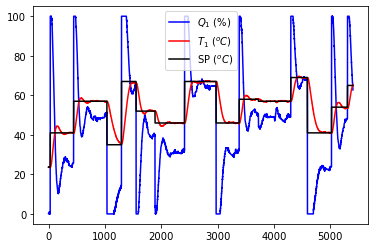

In [5]:
# Save csv file
data = pd.DataFrame()
data['Q1'] = Q1
data['T1'] = T1
data['Tsp'] = Tsp1
data.to_csv('PID_train_data.csv',index=False)

# Plot
plt.plot(data['Q1'],'b-',label='$Q_1$ (%)')
plt.plot(data['T1'],'r-',label='$T_1$ $(^oC)$')
plt.plot(data['Tsp'],'k-',label='SP $(^oC)$')
plt.legend()
plt.savefig('PID_train.png');